# Mini-Project: 나만의 딥러닝 모델로 Mnist Dataset 학습하기

> 2.2.8 장에 해당하는 코드

## 패키기 불러오기 및 GUI 프로그램 작성

In [1]:
# 코드 2-22

import os
# matplotlib 패키지 결과물을 노트북을 실행한 브라우저 안에 보일 수 있도록 하는 명령어다. 
%matplotlib inline
# numpy 와 pytorch 패키지 불러오기 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# 데이터로더 및 mnist 가 내장 되어있는 torchvision 패키지에서 데이터셋 불러오기
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 손글씨를 써볼 수 있는 GUI 프로그램
from drawing import Drawing
# 그림 시각화 처리를 위한 패키지
import matplotlib.pyplot as plt
from PIL import Image

def drawing_custom_number(preprocess, filepath="./figs", return_img=True):
    """손글씨 입력 GUI 미니 프로그램"""
    if (not os.path.isdir("figs")) and (filepath == "./figs"):
        os.mkdir("figs")
    draw = Drawing()
    draw.main(preprocess=preprocess, filepath=filepath)
    img = Image.open(draw.file)
    plt.imshow(img, cmap="gray")
    plt.show()
    if return_img:
        return img

## 데이터 살펴보기

Target: 0
Size of Image: (28, 28)


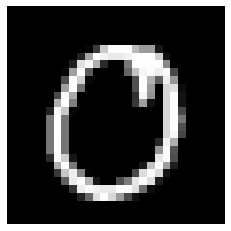

In [2]:
# 코드 2-23

torch.manual_seed(70)

# 데이터셋 정의하기
train_dataset = datasets.MNIST(root='./data',  # 데이터 경로
                               train=True,  # 훈련데이터의 여부
                               download=True,  # 기존에 없다면 root 경로에 다운로드를 받게 된다.
                               transform=transforms.ToTensor())  # 텐서로 바꾸는 전처리를 한다.
test_dataset = datasets.MNIST(root='./data', # 데이터 경로
                              train=False,  # 훈련데이터의 여부
                              transform=transforms.ToTensor())  # 텐서로 바꾸는 전처리를 한다.

# 데이터 살펴보기: 훈련데이터 중 임의의 데이터를 골라서 보여준다
idx = torch.randint(0, len(train_dataset), (1,)).item()
random_image = train_dataset[idx][0].squeeze().numpy()
target_num = train_dataset[idx][1]
print("Target: {}".format(target_num))
print("Size of Image: {}".format(random_image.shape))
plt.imshow(random_image, cmap="gray")
plt.axis("off")
plt.show()

In [3]:
# 코드 2-24

# 미니배치크기
BATCH = 64
# 디바이스 설정: cuda 사용할지 cpu 사용할지
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# 총 스텝 크기
STEP = 10

# 훈련 데이터로더 선언
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH, 
                          shuffle=True)
# 테스트 데이터 로더 설정
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH, 
                         shuffle=True)

In [4]:
for (data, target) in train_loader:
    print(data.size(), target.size())
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [5]:
# 코드 2-30

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.flatten = lambda x: x.view(x.size(0), -1)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

In [6]:
# 코드 2-25

# 모델 선언
model = Net(input_size=28*28, hidden_size=100, output_size=10).to(DEVICE)

In [7]:
# 코드 2-26

# 손실함수와 옵티마이저 선언
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# 매개변수 개수 확인하기
num_params = 0
for params in model.parameters():
    num_params += params.view(-1).size(0)
print("Total number of parameters: {}".format(num_params))

Total number of parameters: 89610


In [8]:
# 코드 2-27

def train(model, train_loader, loss_func, optimizer, step, device, print_step=200):
    """train function: 1 스텝 동안 발생하는 학습과정"""
    # 모델에게 훈련단계이라고 선언함
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # 입력과 타겟 텐서에 GPU 를 사용여부 전달
        data, target = data.to(device), target.to(device)
        # 경사 초기화
        model.zero_grad()
        # 순방향 전파
        output = model(data)
        # 손실값 계산
        loss = loss_func(output, target)
        # 역방향 전파
        loss.backward()
        # 매개변수 업데이트
        optimizer.step()
        # 중간 과정 print
        if batch_idx % print_step == 0:
            print('Train Step: {} ({:05.2f}%)  \tLoss: {:.4f}'.format(
                step, 100.*(batch_idx*train_loader.batch_size)/len(train_loader.dataset), 
                loss.item()))
            
def test(model, test_loader, loss_func, device):
    """test function"""
    # 모델에게 평가단계이라고 선언함
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            # 입력과 타겟 텐서에 GPU 를 사용여부 전달
            data, target = data.to(device), target.to(device)
            # 순방향전파
            output = model(data)
            # 손실값 계산(합)
            test_loss += loss_func(output, target, reduction="sum").item()
            # 예측 값에 해당하는 클래스 번호 반환
            pred = output.softmax(1).argmax(dim=1, keepdim=True)
            # 정확하게 예측한 개수를 기록한다
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:05.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset), 100. * test_acc))
    return test_loss, test_acc

def main(model, train_loader, test_loader, loss_func, optimizer, n_step, device, save_path=None, print_step=200):
    """메인 학습 함수"""
    test_accs = []
    best_acc = 0.0

    for step in range(1, n_step+1):
        # 훈련 단계
        train(model, train_loader, loss_func, optimizer, 
              step=step, device=device, print_step=print_step)
        # 평가 단계
        test_loss, test_acc = test(model, test_loader, 
                                   loss_func=F.cross_entropy, 
                                   device=device)
        # 테스트 정확도 기록
        test_accs.append(test_acc)
        # 모델 최적의 매개변수값을 저장할지 결정하고 기록한다.
        if len(test_accs) >= 2:
            if test_acc >= best_acc:
                best_acc = test_acc
                best_state_dict = model.state_dict()
                print("discard previous state, best model state saved!")
        print("")

    # 매개변수 값 저장하기
    if save_path is not None:
        torch.save(best_state_dict, save_path)

In [9]:
# 코드 2-28

main(model=model, 
     train_loader=train_loader, 
     test_loader=test_loader, 
     loss_func=loss_function, 
     optimizer=optimizer, 
     n_step=STEP,
     device=DEVICE,
     save_path="mnist_model.pt", 
     print_step=200)

Train Step: 1 (00.00%)  	Loss: 2.3176
Train Step: 1 (21.33%)  	Loss: 0.2704
Train Step: 1 (42.67%)  	Loss: 0.3944
Train Step: 1 (64.00%)  	Loss: 0.1376
Train Step: 1 (85.33%)  	Loss: 0.2473
Test set: Average loss: 0.1566, Accuracy: 9543/10000 (95.43%)

Train Step: 2 (00.00%)  	Loss: 0.2037
Train Step: 2 (21.33%)  	Loss: 0.1473
Train Step: 2 (42.67%)  	Loss: 0.1313
Train Step: 2 (64.00%)  	Loss: 0.1170
Train Step: 2 (85.33%)  	Loss: 0.0972
Test set: Average loss: 0.1198, Accuracy: 9610/10000 (96.10%)
discard previous state, best model state saved!

Train Step: 3 (00.00%)  	Loss: 0.0749
Train Step: 3 (21.33%)  	Loss: 0.1048
Train Step: 3 (42.67%)  	Loss: 0.0381
Train Step: 3 (64.00%)  	Loss: 0.0404
Train Step: 3 (85.33%)  	Loss: 0.0462
Test set: Average loss: 0.1066, Accuracy: 9662/10000 (96.62%)
discard previous state, best model state saved!

Train Step: 4 (00.00%)  	Loss: 0.0631
Train Step: 4 (21.33%)  	Loss: 0.0844
Train Step: 4 (42.67%)  	Loss: 0.0425
Train Step: 4 (64.00%)  	Loss: 

file saved ./figs\abc.png


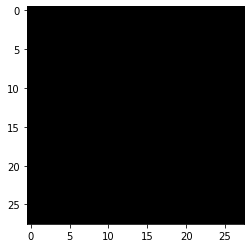

In [10]:
# 만약에 해당 프로그램이 계속 실행안되고 재시작을 한다면 ssh 접속시
# $ ssh -Y [host 이름]
# 으로 실행해주시면 됩니다.
img = drawing_custom_number(preprocess=True, return_img=True)

In [11]:
# 코드 2-29

# 내가 그린 이미지 테스트
# 이미지를 (1, 28, 28) 크기의 텐서로 바꿔준다
test_input = torch.Tensor(np.array(img)).unsqueeze(0).to(DEVICE)
pred = model(test_input)
print("Predicted number is {}.".format(pred.softmax(1).argmax().item()))

Predicted number is 5.
